In [1]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

/Users/yjlee/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [44]:
def sin(x, T=100):
    return np.sin(2.0*np.pi*x/T)

In [45]:
x = np.array([1,2,3,4,5])
sin(x)

array([0.06279052, 0.12533323, 0.18738131, 0.24868989, 0.30901699])

In [46]:
def toy_problem(T=100, ampl=0.05):
    x = np.arange(0, 2*T + 1)
    noise = ampl * np.random.uniform(low=-1.0, high=1.0, size=len(x))
    return sin(x) + noise

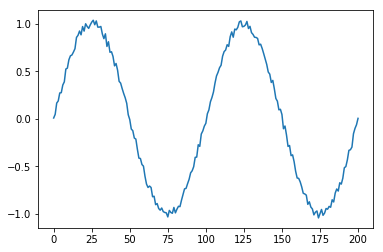

In [47]:
T=100
f = toy_problem(T)
x=np.arange(0, 2*T + 1)
plt.plot(x, f)


In [48]:
length_of_sequences = 2*T
maxlen = 25

data = []
target = []

for i in range(0, length_of_sequences - maxlen +1):
    data.append(f[i:i+maxlen])
    target.append(f[i+maxlen])
    
X = np.array(data).reshape(len(data), maxlen, 1)

In [ ]:
X.shape

In [49]:
Y = np.array(target).reshape(len(data), 1)

In [ ]:
X.shape

In [50]:
import numpy as np
from sklearn.model_selection import train_test_split
N_train = int(len(data)*0.9)
N_validation = len(data)-N_train
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=N_validation)

In [ ]:
X_train.shape

In [51]:
### This is an independent example for zero_state command!
n_hidden=2
n_batch=5
init = tf.global_variables_initializer()
sess = tf.Session()
cell = tf.contrib.rnn.BasicRNNCell(n_hidden)
initial_state = cell.zero_state(n_batch, tf.float32) #need special case here!!!
sess.run(init)
sess.run(initial_state)


array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]], dtype=float32)

In [11]:
#############################
def inference(x, n_batch, maxlen = None, n_hidden = None, n_out = None): # input은 25차원 a는 30차원 y는 1차원 데이터수는 176개입니다.
    def weight_variable(shape):
        return tf.Variable(tf.truncated_normal(shape, stddev=0.01)) # 초기화해주기
    def bias_variable(shape):
        return tf.Variable(tf.zeros(shape))
    
    #cell = tf.contrib.rnn.BasicRNNCell(n_hidden)   # RNN에서 basic cell  -> tf 로 바꾸자
    #initial_state = cell.zero_state(n_batch, tf.float32) # initial state 176x30 
    #state = initial_state # 코드에서는... state로 쓰므로...
    init_state = tf.zeros(shape = (n_batch, n_hidden))
    state = init_state
    
    outputs = []
    n_in = 1; n_out = 1
    Wxh = tf.get_variable('Wxh', shape = (n_in, n_hidden),
                         initializer = tf.contrib.layers.xavier_initializer(), dtype = tf.float32)
    Whh = tf.get_variable('Whh', shape = (n_hidden, n_hidden),
                         initializer = tf.contrib.layers.xavier_initializer(), dtype = tf.float32)
    bh = tf.get_variable('bh', shape = (1, n_hidden),
                         initializer = tf.contrib.layers.xavier_initializer(), dtype = tf.float32)
    

    for t in range(maxlen):   # 25번
        state = tf.tanh(tf.matmul(x[:,t,:], Wxh) + tf.matmul(state, Whh)+bh)
        # x(176, 1)*Wxh(1,30) + h(176, 30)*(30,30) + b => h(176,30)
        outputs.append(state)
    output = outputs[-1] # output은 모든 a 값 중에서 제일 마지막 꺼
    
    
    V = weight_variable([n_hidden, n_out])  # 30x1 
    c = bias_variable([n_out])
    y = tf.matmul(output, V) + c       # a= y(176x30) W(30x1) + b 를 최종 y로 쓴다
    return y

In [30]:
def inference(x, n_batch, maxlen = None, n_hidden = None, n_out = None): # input은 25차원 a는 30차원 y는 1차원 데이터수는 176개입니다.
    def weight_variable(shape):
        return tf.Variable(tf.truncated_normal(shape, stddev=0.01)) # 초기화해주기
    def bias_variable(shape):
        return tf.Variable(tf.zeros(shape))
    
    cell = tf.contrib.rnn.BasicRNNCell(n_hidden)   # RNN에서 basic cell  -> tf 로 바꾸자
    initial_state = cell.zero_state(n_batch, tf.float32) # initial state 176x30 
    state = initial_state # 코드에서는... state로 쓰므로...
    
    outputs = []
    
    with tf.variable_scope("RNN"):  #  RNN의 시작 . 이 안에서 cell이 25번 돌아갈거다. RNN에서 발생되는 variable이 share 되고
        for t in range(maxlen):   # 25번
            
            if t>0: # 첫번째 이후로는 variable 재사용하겠다고 선언해주어야..
                tf.get_variable_scope().reuse_variables()
                
            (cell_output, state) = cell(x[:, t, :], state)  # 둘다 a<t> 인데 LSTM이랑 비슷하게 해주려고 둘다 썼을 뿐
            # cell에서 x와 초기state인 (0,0,,,0)을 받아서 cell_output은 y, state는 a 인데, 각각마다 y와 a를 받겠다. 
            # HW: cell 명령어를 안쓰고 W_aa W_xa 이런거 정의해주어서 tensorflow로 구현하는것 (with 부터 이 다음줄까지만 수정하면 ok)
            outputs.append(cell_output)
            
    output = outputs[-1] # output은 모든 a 값 중에서 제일 마지막 꺼
    
    
    V = weight_variable([n_hidden, n_out])  # 30x1 
    c = bias_variable([n_out])
    y = tf.matmul(output, V) + c       # a= y(176x30) W(30x1) + b 를 최종 y로 쓴다
    return y

In [13]:
n_in = 1; n_out = 1

In [31]:
x = tf.placeholder(tf.float32, shape=[None, maxlen, n_in])
t = tf.placeholder(tf.float32, shape=[None, n_out])
n_batch = tf.placeholder(tf.int32, shape=[])

In [ ]:
# V = tf.Variable(tf.truncated_normal([n_hidden, n_out], stddev=0.01))
# c = tf.Variable( tf.zeros([n_out], dtype=tf.float32) )


In [32]:
y = inference(x,n_batch=n_batch, maxlen=maxlen, n_hidden=n_hidden, n_out=n_out)

In [33]:
def loss(y, t):
    mse = tf.reduce_mean(tf.square(y-t))
    return mse


def training(loss):
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.9, beta2=0.999)
    train_step = optimizer.minimize(loss)
    return train_step

loss = loss(y,t)
train_step = training(loss)

In [34]:
epochs = 500
batch_size = 10

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

n_batches = N_train // batch_size
from sklearn.utils import shuffle

In [35]:
my_loss = []
for epoch in range(epochs):
    X_, Y_ = shuffle(X_train, Y_train)
    
    for i in range(n_batches):
        start = i* batch_size
        end = start + batch_size
    
    sess.run(train_step, feed_dict={
        x: X_[start:end], 
        t: Y_[start:end],
        n_batch: batch_size
    })
    
    val_loss = loss.eval(session=sess, feed_dict={
        x: X_validation, 
        t: Y_validation, 
        n_batch: N_validation
    })
    my_loss.append(val_loss)
    print("epoch:", epoch, "validation loss:", val_loss)

epoch: 0 validation loss: 0.40596968
epoch: 1 validation loss: 0.40508565
epoch: 2 validation loss: 0.40416443
epoch: 3 validation loss: 0.40322712
epoch: 4 validation loss: 0.40228516
epoch: 5 validation loss: 0.4013551
epoch: 6 validation loss: 0.40041023
epoch: 7 validation loss: 0.39946708
epoch: 8 validation loss: 0.39852488
epoch: 9 validation loss: 0.39756453
epoch: 10 validation loss: 0.39658487
epoch: 11 validation loss: 0.39561626
epoch: 12 validation loss: 0.3946711
epoch: 13 validation loss: 0.393726
epoch: 14 validation loss: 0.39275727
epoch: 15 validation loss: 0.39179313
epoch: 16 validation loss: 0.39085427
epoch: 17 validation loss: 0.38991335
epoch: 18 validation loss: 0.38898325
epoch: 19 validation loss: 0.3880623
epoch: 20 validation loss: 0.38711566
epoch: 21 validation loss: 0.38616544
epoch: 22 validation loss: 0.38520637
epoch: 23 validation loss: 0.38426745
epoch: 24 validation loss: 0.38330495
epoch: 25 validation loss: 0.38232666
epoch: 26 validation loss: 

epoch: 248 validation loss: 0.147663
epoch: 249 validation loss: 0.1468599
epoch: 250 validation loss: 0.14606641
epoch: 251 validation loss: 0.14522001
epoch: 252 validation loss: 0.14440578
epoch: 253 validation loss: 0.14356682
epoch: 254 validation loss: 0.14271222
epoch: 255 validation loss: 0.14187826
epoch: 256 validation loss: 0.14107238
epoch: 257 validation loss: 0.14027888
epoch: 258 validation loss: 0.13950291
epoch: 259 validation loss: 0.1387227
epoch: 260 validation loss: 0.13794926
epoch: 261 validation loss: 0.13716382
epoch: 262 validation loss: 0.13640504
epoch: 263 validation loss: 0.13567321
epoch: 264 validation loss: 0.13496466
epoch: 265 validation loss: 0.13429627
epoch: 266 validation loss: 0.13362718
epoch: 267 validation loss: 0.13295478
epoch: 268 validation loss: 0.13228926
epoch: 269 validation loss: 0.1316253
epoch: 270 validation loss: 0.13092214
epoch: 271 validation loss: 0.13026083
epoch: 272 validation loss: 0.12962116
epoch: 273 validation loss: 0.

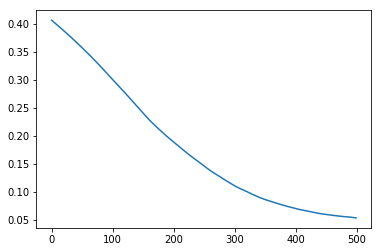

In [36]:
plt.plot(my_loss)

In [37]:
truncate = maxlen
truncate

25

In [38]:
Z=X[:1]

In [39]:
original = [f[i] for i in range(maxlen)]
predicted = [None for i in range(maxlen)]

In [23]:
xx = np.array([1,2,3, 4, 5])

In [25]:
xx[-1:]

array([5])

In [40]:
for i in range(length_of_sequences - maxlen +1):
    z_ = Z[-1:]
    y_ = y.eval(session=sess, feed_dict={
        x: Z[-1:], 
        n_batch: 1
    })
    
    sequence_ = np.concatenate(
        (z_.reshape(maxlen, n_in)[1:], y_), axis=0).reshape(1, maxlen, n_in)
    Z = np.append(Z, sequence_, axis=0)
    predicted.append(y_.reshape(-1))

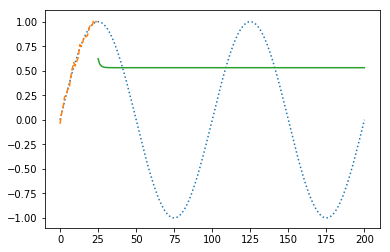

In [43]:
plt.plot(toy_problem(T, ampl=0), linestyle="dotted")
plt.plot(original, linestyle="dashed")
plt.plot(predicted)

In [ ]:
from keras.layers.recurrent import SimpleRNN
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dense

In [ ]:
    def weight_variable(shape):
        return tf.Variable(tf.truncated_normal(shape, stddev=0.01))
    def bias_variable(shape):
        return tf.Variable(tf.zeros(shape))


In [ ]:
        
model = Sequential()
model.add(SimpleRNN(n_hidden, 
                  init=weight_variable, 
                  input_shape=(maxlen, n_out)))

In [ ]:
model.add(Dense(n_out, init=weight_variable))

In [ ]:
model.add(Activation("linear"))

In [ ]:
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(loss="mean_squared_error", optimizer=optimizer)

In [ ]:
epochs = 500
batch_size = 10
model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_validation, Y_validation))

In [ ]:
truncate = maxlen
Z=X[:1]
original = [f[i] for i in range(maxlen)]
predicted = [None for i in range(maxlen)]

for i in range(length_of_sequences-maxlen+1):
    z_ = Z[-1:]
    y_ = model.predict(z_)
    sequence_ = np.concatenate(
       (z_.reshape(maxlen, n_in)[1:], y_), axis=0).reshape(1, maxlen, n_in)
    Z=np.append(z_, sequence_, axis=0)
    predicted.append(y_.reshape(-1))

In [ ]:
plt.plot(toy_problem(T, ampl=0), linestyle="dotted")
plt.plot(original, linestyle="dashed")
plt.plot(predicted)